# Янаков Дмитрий, 317

## **Название задания**: классификация «дотюниным» трансформером

## **Цель задания**: взять несколько предобученных трансоформеров, выбрать одну любую задачу классификации текстов, провести дообучение трансформеров. Разобраться, как их лучше дообучать для получения максимального качества.

## **Датасет**: [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)



## 0. Подготовка

Для начала импортируем все необходимые библиотеки.

In [ ]:
pip install transformers

In [4]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.optim import Adam
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaModel
from transformers import AlbertTokenizer, AlbertModel
from classifiers import BertClassifier, RobertaClassifier
from utils import train, evaluate, get_plot

Загрузим наш датасет. Однако в качестве используемого (для экспериментов) датасета, будем использовать сэмпл из **3000** объектов из исходного датасета, чтобы сэкономить время.

In [18]:
df = pd.read_csv('IMDB_Dataset.csv')
df = df.sample(3000, random_state=42)

Данные представляют из себя отзывы на фильмы. В данном случае они делятся на 2 класса: позитивные и негативные.

In [19]:
df.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative


Выборка является сбалансированной:

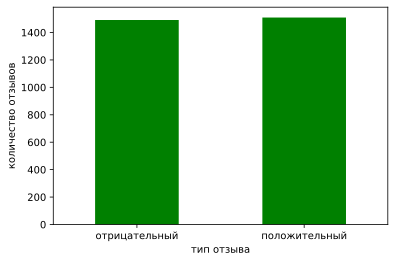

In [20]:
df.groupby(['sentiment']).size().plot.bar(color='green')
plt.xticks(rotation = 0)
plt.ylabel('количество отзывов')
plt.xlabel('тип отзыва')
plt.xticks(ticks=[0,1], labels=['отрицательный', 'положительный'])
plt.show()

In [ ]:
labels = {'negative': 0, 'positive': 1}

Данные поделим в отношении **75:15:15** (трейн:валидация:тест).

In [28]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(0.7*len(df)), int(0.85*len(df))])
print(len(df_train),len(df_val), len(df_test))

2100 450 450


Рассмотрим два предобученных трансформера: **BERT** и **RoBERTa**.

## 1. BERT

Начнем с трансформера **BERT (base-cased)**. Определим токенайзер и класс датасета (который будет также использован далее) для него.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [26]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length):
        self.labels = [labels[label] for label in df['sentiment']]
        self.texts = [tokenizer(text, 
                                padding='max_length', max_length=max_length, truncation=True,
                                return_tensors="pt") for text in df['review']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

В качестве функции потерь выбрана **кросс-энтропия**. Количество эпох для дообучения - **10**.

Дообучение будет происходить с помощью оптимизатора **Adam**.


Переберём следующие параметры, чтобы попробовать увеличить качество (**accuracy**) модели:
* **Для токенайзера**:
  * *максимальную длину последовательности (max_length)*: 64, 128, 256, 512.
* **Для оптимизатора**:
  * *learning_rate*: $10^{-4}, 10^{-5}, 10^{-6}, 10^{-7}$;
  * *weight_decay*: $10^{-2},10^{-3}, ..., 10^{-6}, 0$.
* **Для обучения**:
  * *batch_size*: 2, 4, 8, 16.

Перебор будет происходить поэтапно в том порядке, в каком перечислены параметры. То есть, сначала будет выбрано оптимальное значение *max_length*, затем с полученным значением будет подобрано оптимальное значение *learning_rate* и т.д.

В качестве бейзлайна возьмём следующие параметры:
* *max_length* = 256;
* *learning_rate* = $10^{-6}$;
* *weight_decay* = 0;
* *batch_size* = 8.

In [2]:
model = BertClassifier(num_classes=2)
optimizer = Adam(model.parameters(), lr=1e-6, weight_decay=0)
 
train(model, df_train, df_val, optimizer, epochs=10, max_length=256, batch_size=8)
baseline_acc = evaluate(model, df_test, max_length=256, batch_size=8)
print(baseline_acc)

0.853


Итак, качество на бейзлайне - **0.853**. Попробуем его увеличить!

### 1.1 max_length

Начнем с нахождения оптимального значения параметра *max_length* для токенайзера.

In [ ]:
max_length_list = [64, 128, 512]
max_length_acc = dict()
optimizer = Adam(model.parameters(), lr=1e-6)
for max_length in max_length_list:
  model = BertClassifier(num_classes=2)
  train(model, df_train, df_val, optimizer, epochs=10, max_length=max_length, batch_size=8)
  acc = evaluate(model, df_test, max_length=max_length, batch_size=8)
  max_length_acc[max_length] = acc

max_length_acc[256] = baseline_acc

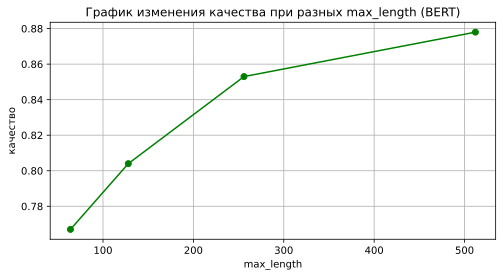

In [42]:
get_plot(acc_dict=max_length_acc, 
         title='График изменения качества при разных max_length (BERT)', 
         xlabel='max_length')

Наилучшее качество получилось при max_length = 512 - **0.878**. Результат скорее ожидаем, чем нет, поскольку средняя длина отзыва немаленькая:

In [24]:
int(df['review'].apply(len).mean())

1326

Больше 512 слов **BERT** не принимает (вернее принимает, но обрезает), поэтому остановимся на этом значении.

### 1.2 learning_rate

Теперь переберём значения для learning_rate.

In [ ]:
learning_rate_list = [1e-4,1e-5,1e-7]
learning_rate_acc = dict()
for learning_rate in learning_rate_list:
  model = BertClassifier(num_classes=2)
  optimizer = Adam(model.parameters(), lr=learning_rate)
  train(model, df_train, df_val, optimizer, epochs=10, max_length=512, batch_size=8)
  acc = evaluate(model, df_test, max_length=512, batch_size=8)
  learning_rate_acc[learning_rate] = acc

learning_rate_acc[1e-6] = max_length_acc[512]

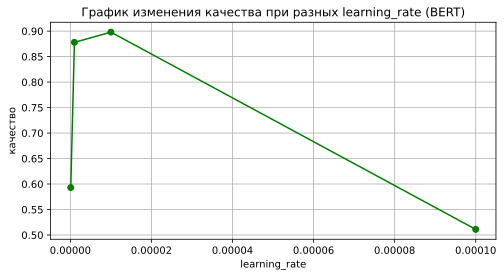

In [44]:
get_plot(acc_dict=learning_rate_acc, 
         title='График изменения качества при разных learning_rate (BERT)', 
         xlabel='learning_rate')

Наилучшим оказалось значение learning_rate = $10^{-5}$. Качество при нём - **0.898**. 

### 1.3 weight_decay

При обучении, по логам было видно, что возникает переобучение. Попробуем добавить регуляризатор (weight_decay), чтобы улучшить качество на тесте.

In [ ]:
weight_decay_list = list(np.logspace(-6,-2,5))
weight_decay_list.append(0)
weight_decay_acc = dict()
for weight_decay in weight_decay_list:
  model = BertClassifier(num_classes=2)
  optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=weight_decay)
  train(model, df_train, df_val, optimizer, epochs=10, max_length=512, batch_size=8)
  acc = evaluate(model, df_test, max_length=512, batch_size=8)
  weight_decay_acc[weight_decay] = acc

weight_decay_acc[0] = learning_rate_acc[1e-5]

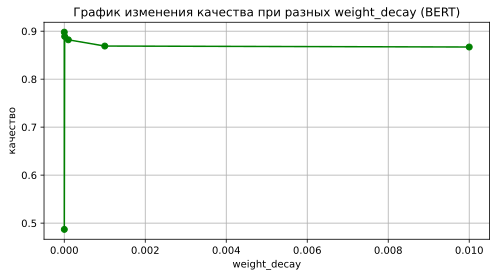

In [46]:
get_plot(acc_dict=weight_decay_acc, 
         title='График изменения качества при разных weight_decay (BERT)', 
         xlabel='weight_decay')

Здесь значения вблизи нуля склеились. Поэтому приведём еще один график для значений $0, 10^{-4}, 10^{-5}, 10^{-6}$.

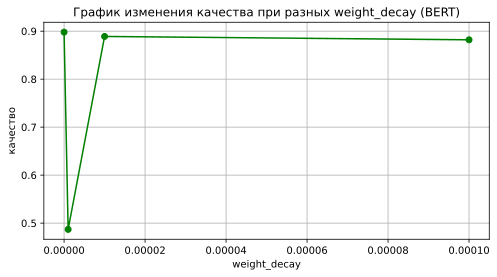

In [47]:
get_plot(acc_dict={key: weight_decay_acc[key] for key in [0,1e-6,1e-5,1e-4]}, 
         title='График изменения качества при разных weight_decay (BERT)', 
         xlabel='weight_decay')

Как можно заметить, weight_decay не дал никакого прироста по качеству. Наилучшая стратегия в нашем случае - не использовать регуляризатор (weight_decay=0). Возможно, это связано с тем, что в классификаторе (BertClassifier) уже присутствует DropOut слой.

### 1.4 batch_size

Попробуем поварьировать размер батча.

In [ ]:
batch_size_list = [2,4,16]
batch_size_acc = dict()
for batch_size in batch_size_list:
  model = BertClassifier(num_classes=2)
  optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=0)
  train(model, df_train, df_val, optimizer, epochs=10, max_length=512, batch_size=batch_size)
  acc = evaluate(model, df_test, max_length=512, batch_size=batch_size)
  batch_size_acc[batch_size] = acc

batch_size_acc[8] = weight_decay_acc[0]

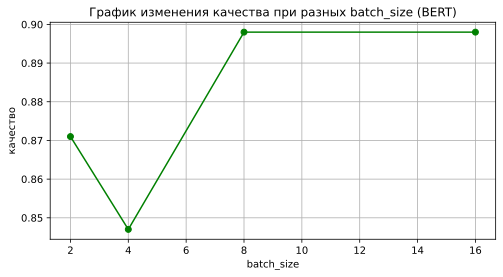

In [49]:
get_plot(acc_dict=batch_size_acc, 
         title='График изменения качества при разных batch_size (BERT)', 
         xlabel='batch_size')

Качество при размере 8 и 16 оказалось одинаковым (возможно, взяв еще больше, получилось бы больше качество), при 2 и 4 - ниже.

**P.S.:** хотелось еще посмотреть (на **RoBERT'е** тоже), что происходит при батчах 32+, но GPU колаба не хватало памяти :(

### Выводы для BERT

На бейзлайне качество было **0.853**. \
Перебор параметров max_length и learning_rate помог повысить качество до **0.898**. \
Перебор параметров weight_decay и batch_size не показал улучшений в качестве.

## 2. RoBERTa

Теперь рассмотрим трансформер **RoBERTa (base)**. Определим токенайзер для него.

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Функция потерь, количество эпох и оптимизатор остаются такими же, как и в случае с **BERT'ом**.

Параметры перебираются те же. \
Параметры для бейзлайна остаются такими же:
* *max_length* = 256;
* *learning_rate* = $10^{-6}$;
* *weight_decay* = 0;
* *batch_size* = 8.

In [29]:
model = RobertaClassifier(num_classes=2)
optimizer = Adam(model.parameters(), lr=1e-6, weight_decay=0)
              
train(model, df_train, df_val, optimizer, epochs=10, max_length=256, batch_size=8)
baseline_acc = evaluate(model, df_test, max_length=256, batch_size=8)
print(baseline_acc)

0.92


Качество на бейзлайне **RoBERT'а** превысило наилучший результат **BERT'а** (0.898)! Попробуем ещё улучшить его!

### 2.1 max_length

In [ ]:
max_length_list = [64, 128, 512]
max_length_acc = dict()
optimizer = Adam(model.parameters(), lr=1e-6)
for max_length in max_length_list:
  model = RobertaClassifier(num_classes=2)
  train(model, df_train, df_val, optimizer, epochs=10, max_length=max_length, batch_size=8)
  acc = evaluate(model, df_test, max_length=max_length, batch_size=8)
  max_length_acc[max_length] = acc

max_length_acc[256] = baseline_acc

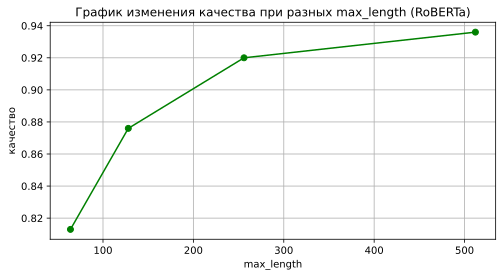

In [37]:
get_plot(acc_dict=max_length_acc, 
         title='График изменения качества при разных max_length (RoBERTa)', 
         xlabel='max_length')

Ситуация аналогична с **BERT'ом**. Значение max_length = 512 - наилучшее, а качество достигаемое при нем - **0.936**.

### 2.2 learning_rate

In [ ]:
learning_rate_list = [1e-4,1e-5,1e-7]
learning_rate_acc = dict()
for learning_rate in learning_rate_list:
  model = RobertaClassifier(num_classes=2)
  optimizer = Adam(model.parameters(), lr=learning_rate)
  train(model, df_train, df_val, optimizer, epochs=10, max_length=512, batch_size=8)
  acc = evaluate(model, df_test, max_length=512, batch_size=8)
  learning_rate_acc[learning_rate] = acc

learning_rate_acc[1e-6] = max_length_acc[512]

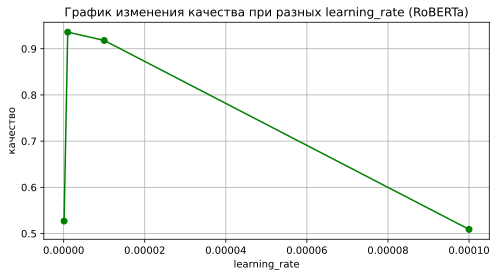

In [38]:
get_plot(acc_dict=learning_rate_acc, 
         title='График изменения качества при разных learning_rate (RoBERTa)', 
         xlabel='learning_rate')

В данном случае перебор learning_rate не дал улучшений, поэтому оставим значением learning_rate = $10^{-6}$.

### 2.3 weight_decay

Может на **RoBERT'е** получится уменьшить переобучение?

In [ ]:
weight_decay_list = list(np.logspace(-6,-2,5))
weight_decay_list.append(0)
weight_decay_acc = dict()
for weight_decay in weight_decay_list:
  model = RobertaClassifier(num_classes=2)
  optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=weight_decay)
  train(model, df_train, df_val, optimizer, epochs=10, max_length=512, batch_size=8)
  acc = evaluate(model, df_test, max_length=512, batch_size=8)
  weight_decay_acc[weight_decay] = acc

weight_decay_acc[0] = learning_rate_acc[1e-6]

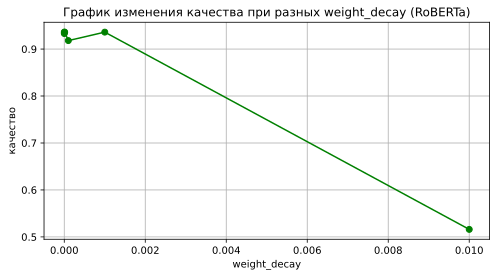

In [39]:
get_plot(acc_dict=weight_decay_acc, 
         title='График изменения качества при разных weight_decay (RoBERTa)', 
         xlabel='weight_decay')

Здесь значения вблизи нуля также склеились. Поэтому приведём еще один график для значений $0, 10^{-4}, 10^{-5}, 10^{-6}$.

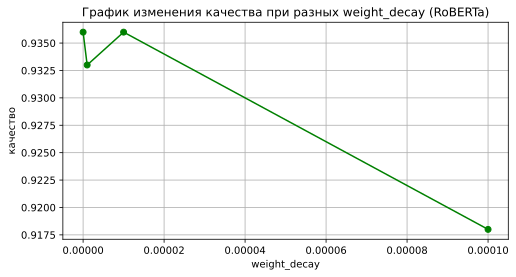

In [40]:
get_plot(acc_dict={key: weight_decay_acc[key] for key in [0,1e-6,1e-5,1e-4]}, 
         title='График изменения качества при разных weight_decay (RoBERTa)', 
         xlabel='weight_decay')

Регуляризация в данном случае тоже не помогла, но в двух значениях параметра weight_decay ($10^{-3}, 10^{-4}$) качество совпало с уже имеющимся (при weight_decay=0), поэтому, возможно, делая мы более полный перебор, с помощью данного параметра удалось бы повысить качество.

### 2.4 batch_size

In [ ]:
batch_size_list = [2,4,16]
batch_size_acc = dict()
for batch_size in batch_size_list:
  model = RobertaClassifier(num_classes=2)
  optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=0)
  train(model, df_train, df_val, optimizer, epochs=10, max_length=512, batch_size=batch_size)
  acc = evaluate(model, df_test, max_length=512, batch_size=batch_size)
  batch_size_acc[batch_size] = acc

batch_size_acc[8] = weight_decay_acc[0]

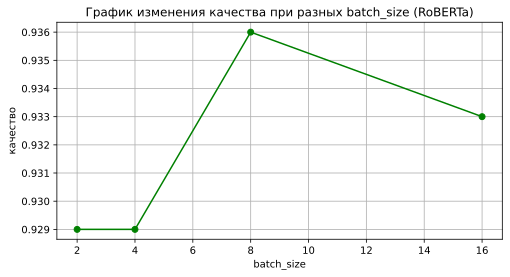

In [51]:
get_plot(acc_dict=batch_size_acc, 
         title='График изменения качества при разных batch_size (RoBERTa)', 
         xlabel='batch_size')

Варьирование батча не дало результата. Наилучшим качество осталось при размере, равным 8.

### Вывод для RoBERTa

На бейзлайне качество было **0.92**.

Перебор параметра max_length помог повысить качество до **0.936**.

Перебор параметров learning_rate, weight_decay и batch_size не показал улучшений в качестве, однако некоторые были близки к тому, чтобы улучшить.

## 3. Выводы

Конечно, исходя из экспериментов сложно сделать какие-то выводы, поскольку, во-первых, перебор является не полным (хоть повысить качество и удалось), а, во-вторых, варьирование разных параметров приводит к разным результатам. Однако точно можно отметить то, что параметр **max_length** токенайзера играет важную роль при повышении качества.

Приведём еще раз результаты проведённой работы:


| Трансформер | Accuracy на бейзлайне | Максимально полученное accuracy |
| --- | --- | --- |
| BERT | 0.853 | 0.898 |
| RoBERTa | 0.920 | 0.936 |

**P.S.**: некоторый код был взят [отсюда](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)